In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import seaborn as sns

# Step 2: Feature Scaling

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/dataset/filtered_attacks (1).csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 1. Feature Engineering: Creating new specific features
# These features are designed to capture differences in protocol behavior and traffic flow
df['Fwd_Bwd_Pkts_Ratio'] = df['Total Fwd Packets'] / (df['Total Backward Packets'] + 1)
df['Total_Bytes'] = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']
df['Header_to_Data_Ratio'] = (df['Fwd Header Length'] + df['Bwd Header Length']) / (df['Total_Bytes'] + 1)
df['Bwd_to_Fwd_Bytes_Ratio'] = df['Total Length of Bwd Packets'] / (df['Total Length of Fwd Packets'] + 1)
df['Flow_IAT_Range'] = df['Flow IAT Max'] - df['Flow IAT Min']
df['Avg_IAT'] = df['Flow Duration'] / (df['Total Fwd Packets'] + df['Total Backward Packets'] + 1)
df['Packet_Size_Spread'] = df['Max Packet Length'] - df['Min Packet Length']

# 2. Preparation for Evaluation
# Dropping duplicates and balancing for a fair assessment
df_clean = df.drop_duplicates(subset=[c for c in df.columns if c != 'Label'])
df_balanced = df_clean.groupby('Label').apply(lambda x: x.sample(n=min(len(x), 1900), random_state=42)).reset_index(drop=True)



X = df_balanced.drop(columns=['Label'])
if 'Destination Port' in X.columns:
    X = X.drop(columns=['Destination Port'])
y = df_balanced['Label']

# 3. Check Importance of New Features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

new_features = ['Fwd_Bwd_Pkts_Ratio', 'Total_Bytes', 'Header_to_Data_Ratio', 'Bwd_to_Fwd_Bytes_Ratio', 'Flow_IAT_Range', 'Avg_IAT', 'Packet_Size_Spread']
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Importance of newly engineered features:")
print(importances[new_features].sort_values(ascending=False))

# 4. Clustering with Engineered Features
# Use PowerTransformer on the full set of features (including new ones)
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_transformed)

/tmp/ipykernel_55/4045891394.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_clean.groupby('Label').apply(lambda x: x.sample(n=min(len(x), 1900), random_state=42)).reset_index(drop=True)


Importance of newly engineered features:
Total_Bytes               0.028664
Header_to_Data_Ratio      0.024856
Bwd_to_Fwd_Bytes_Ratio    0.024610
Avg_IAT                   0.021237
Fwd_Bwd_Pkts_Ratio        0.014688
Flow_IAT_Range            0.013044
Packet_Size_Spread        0.012644
dtype: float64


# Step 3: Find Optimal DBSCAN Parameters

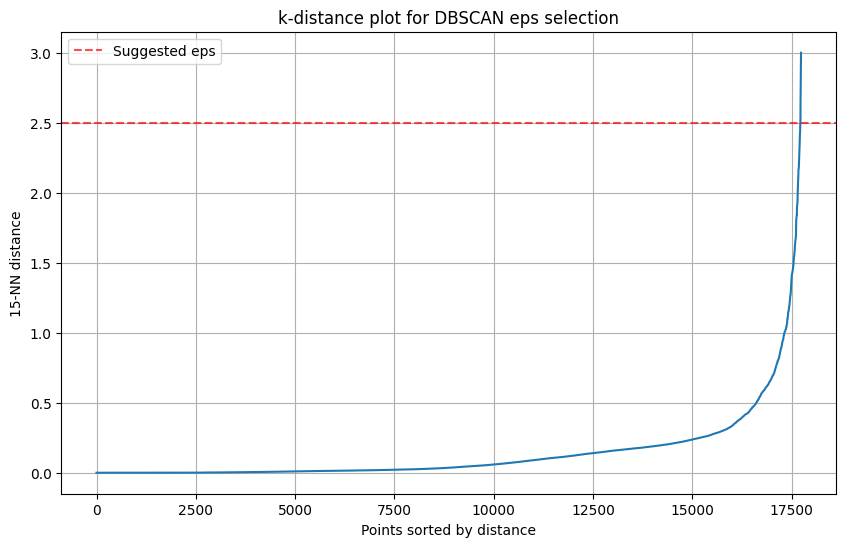

DBSCAN Parameter Evaluation Results:
    eps  min_samples  n_clusters  silhouette  calinski_harabasz  noise_ratio
17  0.2          460          11    0.944380      566549.936883     0.545101
16  0.2          455          11    0.944291      564991.872943     0.544763
15  0.2          450          11    0.944283      564838.820747     0.544706
13  0.2          440          11    0.944271      564574.604740     0.544650
14  0.2          445          11    0.944271      564574.604740     0.544650
12  0.2          435          11    0.944253      564118.199837     0.544594
5   0.2          300          12    0.943818      536975.012822     0.522156
18  0.2          465          10    0.943724      605391.404884     0.571090
11  0.2          430          11    0.943703      556209.911859     0.543466
10  0.2          425          11    0.943686      555797.698385     0.543410


In [3]:
# Method A: Elbow Method for eps
from sklearn.neighbors import NearestNeighbors

# k = min(10, len(X_scaled) // 20)  # Rule of thumb
n_samples = len(X_scaled)
k = min(15, int(np.sqrt(n_samples)))

nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.title('k-distance plot for DBSCAN eps selection')
plt.axhline(y=2.5, color='r', linestyle='--', alpha=0.7, label='Suggested eps')
plt.grid(True)
plt.legend()
plt.show()

# Method B: Grid Search for DBSCAN parameters
from sklearn.metrics import silhouette_score, calinski_harabasz_score

def evaluate_dbscan_params(X, eps_range, min_samples_range):
    results = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Only evaluate if we have at least 2 clusters and not all noise
            unique_labels = np.unique(labels[labels != -1])
            if len(unique_labels) > 1:
                # Filter out noise for scoring
                valid_mask = labels != -1
                if np.sum(valid_mask) > len(unique_labels):
                    try:
                        sil_score = silhouette_score(X[valid_mask], labels[valid_mask])
                        ch_score = calinski_harabasz_score(X[valid_mask], labels[valid_mask])
                        noise_ratio = (labels == -1).mean()

                        results.append({
                            'eps': eps,
                            'min_samples': min_samples,
                            'n_clusters': len(unique_labels),
                            'silhouette': sil_score,
                            'calinski_harabasz': ch_score,
                            'noise_ratio': noise_ratio
                        })
                    except:
                        continue

    return pd.DataFrame(results)

# Test parameter ranges
eps_range = np.array([0.2, 1.0, 3.0, 5.0]) # Corrected from np.arange to np.array
min_samples_range = [ 380, 385, 390, 395, 400,300, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460 , 465 ]
# eps_range = np.arange(0.5, 3.0, 0.2)  # Adjusted range
# min_samples_range = [3, 5, 7, 10, 15]  # Lower values to start

results_df = evaluate_dbscan_params(X_scaled, eps_range, min_samples_range)
print("DBSCAN Parameter Evaluation Results:")
print(results_df.sort_values('silhouette', ascending=False).head(10))

# Step 4: Apply Optimized DBSCAN

Optimal Parameters: eps=0.2, min_samples=460
Clusters found: 11
Noise points: 9669 (54.51%)
DBSCAN Cluster Purity (excluding noise):
    Cluster   Dominant Attack  Purity (%)  Total Samples
0         0               Bot       92.99            628
1         1               Bot      100.00            602
2         2               Bot       99.78            461
3         3  DoS Slowhttptest       99.90            984
4         4     DoS slowloris       91.41            547
5         5     DoS slowloris       99.65            569
6         6       FTP-Patator      100.00            912
7         7       FTP-Patator      100.00            584
8         8          PortScan      100.00            892
9         9          PortScan      100.00            978
10       10       SSH-Patator      100.00            912
Noise (Outliers) detected: 54.51%


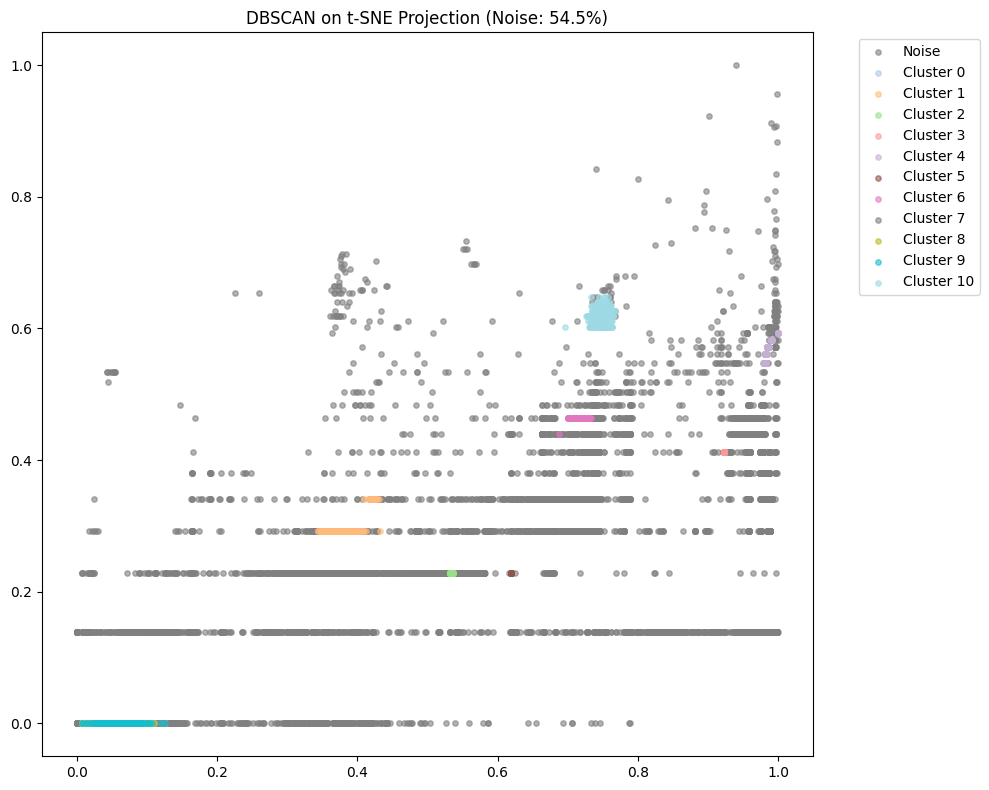

In [4]:
# Based on evaluation, choose best parameters
best_params = results_df.loc[results_df['silhouette'].idxmax()]
eps_opt = best_params['eps']
min_samples_opt = int(best_params['min_samples']) # Convert to int
# best_params = results_df.loc[results_df['silhouette'].idxmax()]
# eps_opt = 1.0
# min_samples_opt = 60
dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples_opt, metric='euclidean')
db_labels = dbscan.fit_predict(X_scaled)

# # DBSCAN on t-SNE space (requires different eps)
# dbscan = DBSCAN(eps=3, min_samples=10)
# db_labels = dbscan_tsne.fit_predict(X_tsne_3d)

print(f"Optimal Parameters: eps={eps_opt}, min_samples={min_samples_opt}")
print(f"Clusters found: {len(np.unique(db_labels[db_labels != -1]))}")
print(f"Noise points: {(db_labels == -1).sum()} ({(db_labels == -1).mean()*100:.2f}%)")

# Add to dataframe
df_balanced['DBSCAN_Cluster'] = db_labels



# Calculate Purity for DBSCAN (excluding -1 which is noise)
valid_clusters = [c for c in np.unique(db_labels) if c != -1]
db_purity_stats = []

for cluster in valid_clusters:
    cluster_data = df_balanced[df_balanced['DBSCAN_Cluster'] == cluster]['Label']
    dominant_attack = cluster_data.mode()[0]
    dominant_count = (cluster_data == dominant_attack).sum()
    total_in_cluster = len(cluster_data)
    purity = (dominant_count / total_in_cluster) * 100
    db_purity_stats.append({
        'Cluster': cluster,
        'Dominant Attack': dominant_attack,
        'Purity (%)': round(purity, 2),
        'Total Samples': total_in_cluster
    })

db_purity_df = pd.DataFrame(db_purity_stats)
print("DBSCAN Cluster Purity (excluding noise):")
print(db_purity_df)

# Percentage of data considered noise
noise_ratio = (df_balanced['DBSCAN_Cluster'] == -1).mean() * 100
print(f"Noise (Outliers) detected: {noise_ratio:.2f}%")


# Visualize DBSCAN
plt.figure(figsize=(10, 8))
# Use a palette that handles -1 (noise) as grey
unique_labels = np.unique(db_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    mask = (db_labels == label)
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                c='grey' if label == -1 else [colors[i]],
                label=f'Cluster {label}' if label != -1 else 'Noise',
                alpha=0.6, s=15)

plt.title(f'DBSCAN on t-SNE Projection (Noise: {noise_ratio:.1f}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('dbscan_tsne_clusters.png')